In [2]:
import os
import numpy as np
from PIL import Image

def load_images_and_labels(folder_path):
    images = []
    labels = []
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):

            image_path = os.path.join(folder_path, filename)
            image = Image.open(image_path)
            image = image.convert("RGB")
            
            image_array = np.array(image) / 255.0
            images.append(image_array)
            
            if ("target" in filename) & ("nontarget" not in filename):
                labels.append(1)
            elif "nontarget" in filename:
                labels.append(-1)
            else:
                raise ValueError("Invalid filename format")
    
    return np.array(images), np.array(labels)

In [3]:
folder_path = "/Users/yohanabeysinghe/Mac/1. ENTC/FYP - Ear EEG/Datasets/ConvertedToImages"
X, Y = load_images_and_labels(folder_path)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape) 

Shape of X: (314, 576, 2304, 3)
Shape of Y: (314,)


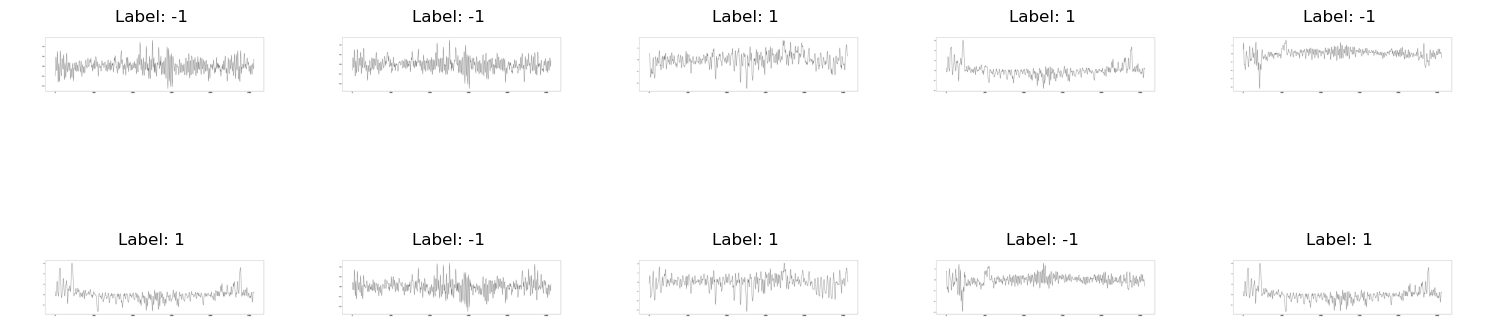

In [4]:
import matplotlib.pyplot as plt

# Select 10 random indices
num_samples = X.shape[0]
random_indices = np.random.choice(num_samples, size=10, replace=False)

# Plot the selected images
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i, idx in enumerate(random_indices):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(X[idx])
    axes[row, col].set_title("Label: {}".format(Y[idx]))
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [5]:
print(Y)

[-1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1  1  1  1 -1 -1 -1 -1 -1 -1 -1
 -1 -1]


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

num_samples, height, width, channels = X.shape
X_flat = X.reshape(num_samples, height * width * channels)

X_train, X_test, Y_train, Y_test = train_test_split(X_flat, Y, test_size=0.2, random_state=42)

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

rf_classifier.fit(X_train, Y_train)
Y_pred = rf_classifier.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print("Accuracy:", accuracy)


Accuracy: 1.0


In [28]:
X_test[0].shape

(3981312,)

In [49]:
from lime import lime_image

explainer = lime_image.LimeImageExplainer()

image_to_explain = X_test[0]
label_to_explain = Y_test[0]

explanation = explainer.explain_instance(image_to_explain, rf_classifier.predict_proba, top_labels=2, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(label_to_explain, positive_only=True, num_features=5, hide_rest=False)
plt.imshow(lime_image.mark_boundaries(temp / 2 + 0.5, mask))
plt.title("Explanation for class {}".format(label_to_explain))
plt.axis('off')
plt.show()

ValueError: the input array must have size 3 along `channel_axis`, got (1, 3981312, 1)

In [35]:
import skimage.segmentation
import skimage.io
import copy
import sklearn
from sklearn.linear_model import LinearRegression

In [11]:
X_train[0].shape

(3981312,)

In [12]:
Xi = Image.open("/Users/yohanabeysinghe/Mac/1. ENTC/FYP - Ear EEG/Datasets/ConvertedToImages/nontarget_s01_trial_00.png")
Xi = Xi.convert("RGB")
Xi = Xi.resize((2304, 576))
Xi = np.array(Xi) / 255.0
Xi_flat = Xi.flatten().reshape(1, -1)
Xi_flat.shape

(1, 3981312)

(576, 2304, 3)

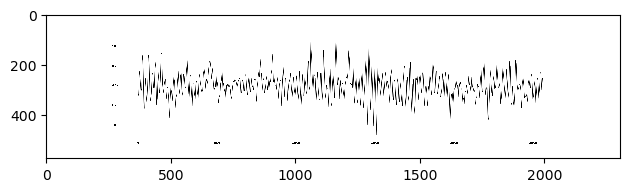

In [13]:
skimage.io.imshow(Xi)
Xi.shape

In [47]:
preds = rf_classifier.predict(Xi_flat)
print(preds)

[-1]


In [23]:
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

1548

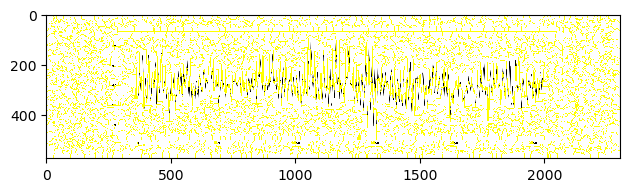

In [24]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi, superpixels))

In [25]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0]

array([1, 1, 0, ..., 1, 0, 1])

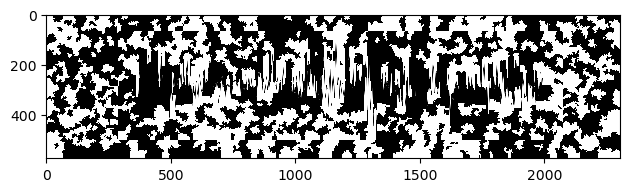

In [26]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image


skimage.io.imshow(perturb_image(Xi,perturbations[0],superpixels))

In [27]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = rf_classifier.predict(perturbed_img.flatten().reshape(1, -1))
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1)

In [29]:
predictions

array([[-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],

In [31]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

In [32]:
distances

array([0.3170591 , 0.28426688, 0.29609799, 0.29518086, 0.30301498,
       0.28924831, 0.28426688, 0.29243658, 0.28111485, 0.28879401,
       0.29015779, 0.2897029 , 0.28879401, 0.29701633, 0.28788628,
       0.31328592, 0.30070172, 0.29977855, 0.29015779, 0.2897029 ,
       0.28426688, 0.29152418, 0.2802168 , 0.28697971, 0.29609799,
       0.28652686, 0.28111485, 0.30394244, 0.30719833, 0.28336488,
       0.28562201, 0.28607429, 0.2897029 , 0.28381574, 0.28834001,
       0.28607429, 0.29931742, 0.29152418, 0.30487114, 0.2897029 ,
       0.28201401, 0.2847183 , 0.28697971, 0.29931742, 0.28879401,
       0.29106842, 0.29335015, 0.29563927, 0.29563927, 0.29563927,
       0.30673226, 0.29793586, 0.30023998, 0.28336488, 0.28426688,
       0.29839608, 0.29380738, 0.30394244, 0.29198023, 0.28788628,
       0.28924831, 0.27618938, 0.29289322, 0.29839608, 0.29152418,
       0.28291431, 0.30116376, 0.29701633, 0.29380738, 0.30813139,
       0.29426491, 0.30394244, 0.28743285, 0.30487114, 0.28834

In [33]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [48]:
class_to_explain = preds[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

0.0

In [45]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([0])

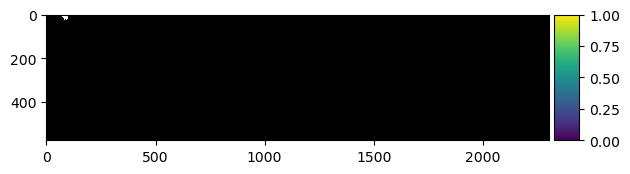

In [46]:
mask = np.zeros(num_superpixels) 
mask[top_features]= True #Activate top superpixels
skimage.io.imshow(perturb_image(Xi,mask,superpixels) )